In [ ]:
# run note book under /SLUG
%cd ..

In [ ]:
%load_ext autoreload
%autoreload 2

import requests
import torch

from functools import partial
from itertools import islice
from typing import Callable, List, Optional, Sequence, Union

import torch
import torch.nn.functional as F
from torch import nn

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from pathlib import Path


from transformers import CLIPProcessor, CLIPModel
from accelerate import Accelerator
import warnings
warnings.filterwarnings('ignore')
accelerator = Accelerator()
device = accelerator.device

**Step 0**: Compute CLIP gradient on forget and retain sets

**Step 1**: Load forget and retain gradients, compute gradient alignment, update CLIP model to achieve unlearning identity/concept on CLIP

**Step 2**: Update the layer of stable diffusion corrsponding to the updated layer of CLIP to achieve unlearning identity/concept on SD

## Step 0: Compute gradients

In [3]:
import os, logging
from pathlib import Path

import webdataset as wds
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

def log_and_continue(exn):
    """Call in an exception handler to ignore any exception, issue a warning, and continue."""
    logging.warning(f'Handling webdataset error ({repr(exn)}). Ignoring.')
    return True

def filter_no_caption_or_no_image(sample):
    has_caption = ('txt' in sample)
    has_image = ('png' in sample or 'jpg' in sample or 'jpeg' in sample or 'webp' in sample)
    return has_caption and has_image

def create_wds(input_shards, bs=4):
    pipeline = [wds.SimpleShardList(input_shards)]
    pipeline.extend([
                wds.split_by_worker,
                wds.tarfile_to_samples(handler=log_and_continue),
                wds.select(filter_no_caption_or_no_image),
                wds.decode("pilrgb", handler=log_and_continue),
                wds.rename(image="jpg;png;jpeg;webp", text="txt"),

                wds.to_tuple("image", "text"),
                wds.batched(bs, partial=True)
            ])

    dataset = wds.DataPipeline(*pipeline)

    dataloader = wds.WebLoader(
            dataset,
            batch_size=None,
            shuffle=False,
            num_workers=1,
            persistent_workers=True,
        )

    return dataloader


def identify_pareto(scores):
        # Initialize a list to store the index of Pareto points
        pareto_index = []
        # Loop through all points
        for i, (x, y) in enumerate(scores):
            dominated = False
            for j, (x2, y2) in enumerate(scores):
                # Check if point (x2, y2) dominates (x, y)
                if x2 < x and y2 > y:
                    dominated = True
                    break
            if not dominated:
                pareto_index.append(i)
        return pareto_index


def get_important_layers(celeb_name, pair, model, forget_grads, retain_grads):
    model_name, ckpt = pair.split(' ')
    
    forget_importances = forget_grads
    retain_importances = retain_grads
    # get model parameters
    model_params = {}
    for idx, (k, p) in enumerate(model.named_parameters()):
        model_params[k] = p.data
    
    # get forget importance ratio
    forget_ratio_dict = {}
    for layer_name in model_params:
        params_norm = torch.norm(model_params[layer_name]).item()
        grad_norm = torch.norm(forget_importances[layer_name]).item()
        if grad_norm > 0:
            forget_ratio_dict[layer_name] = grad_norm / params_norm

    # sort
    ranked_forget_ratio = {k: v for k, v in sorted(forget_ratio_dict.items(), key=lambda item: item[1], reverse=True)}

    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    cosine_dict = {}
    for layer_name in model_params:
        if len(retain_importances[layer_name].shape) > 0:
            cosine_dict[layer_name] = abs(cos(retain_importances[layer_name].flatten(), forget_importances[layer_name].flatten())).item()
    ranked_cos_name_list = []
    ranked_cos = {k: v for k, v in sorted(cosine_dict.items(), key=lambda item: item[1], reverse=True)}

    important_layers = {}
    save_root = Path(f'results/output-SD/{model_name}/{celeb_name}/')
    save_root.mkdir(parents=True, exist_ok=True)

    # for part in ['vision', 'language']:
    for part in ['language']: # SD uses only CLIP text encoder
        # make plot
        name_list = []
        x_cos_list = []
        y_ratio_list = []
        for key in ranked_cos:
            if "bias" in key: continue
            if 'logit_scale' in key: continue
            if 'position' in key: continue
            if 'embedding' in key: continue
            # if '.ln_' in key: continue
            if part == "vision" and "vision_model" not in key: continue
            if part != "vision" and "vision_model" in key: continue
            
            name_list.append(key)
            x_cos_list.append(ranked_cos[key])
            y_ratio_list.append(ranked_forget_ratio[key])
        
        
        # Use the function to find Pareto front
        pareto_indices = identify_pareto(list(zip(x_cos_list, y_ratio_list)))

        font_size = 12
        line_width = 3
        fig = plt.figure()
        # ax = fig.add_subplot(111)

        for idx, (name, x, y) in enumerate(zip(name_list, x_cos_list, y_ratio_list)):
            # if name in ranked_forget_ratio_name_list[:5] or name in ranked_cos_name_list[-5:]:
            if idx in pareto_indices:
                if part not in important_layers:
                    important_layers[part] = [name]
                else:
                    important_layers[part].append(name)
                # plt.scatter(x, y, label=name)
                if 'norm' in name or 'gamma' in name:
                    plt.scatter(x, y, marker='x', c='k')
                    continue
                if part == 'vision':
                    plt.scatter(x, y, label=name.replace('visual.transformer.resblocks.', '').replace('.weight', '').replace('_weight', ''))
                else:
                    plt.scatter(x, y, label=name.replace('transformer.resblocks.', '').replace('.weight', '').replace('_weight', ''))                
            else:
                plt.scatter(x, y, marker='x', c='k')
        plt.xscale('log')
        plt.yscale('log')


        plt.legend(loc='lower left', bbox_to_anchor=(0, 0), prop={'size': 10}, fancybox=True, framealpha=0.5)
        plt.xlabel("Gradient Alignment", fontsize=font_size, weight='bold')
        plt.ylabel("Importance of Layers", fontsize=font_size, weight='bold')

        plt.tight_layout()
        plt.savefig(save_root/f'pareto-{part}-{celeb_name}.pdf')
        plt.savefig(save_root/f'pareto-{part}-{celeb_name}.png')
        plt.close()

    return important_layers


In [4]:
pair = "ViT-H-14 laion2B-s32B-b79K"
clip_model_id = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
celeb_name = 'Elon_Musk'
model_repo, model_name = clip_model_id.split('/')

model_clip_pretrained = CLIPModel.from_pretrained(clip_model_id)
processor_clip = CLIPProcessor.from_pretrained(clip_model_id)
model_clip_pretrained.to(device)
model_clip_pretrained.eval();

In [ ]:
gradient_list = []
for split in ['forget', 'train']:
    gradients = dict([(n, torch.zeros_like(p, device=p.device)) for n, p in model_clip_pretrained.named_parameters()])

    if split == 'forget':            
        path = Path(f"data/tar_files/{celeb_name}.tar")
    else:
        path = Path("data/laion/laion400m/00000.tar")
    dataloader = create_wds(str(path),bs=4)
    for i, (images, texts) in tqdm(enumerate(dataloader)):
        # for openai models replace the original text with just name of the celeb
        texts = [celeb_name.replace('_', ' ')] * len(texts)

        inputs = processor_clip(
            text=texts, images=images, return_tensors="pt", padding=True,
            truncation=True,      # Enable truncation
            max_length=77         # Set the maximum length to 77 tokens
        ).to(device)
        outputs = model_clip_pretrained(**inputs, return_loss=True)
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds
        if split == 'forget':
            total_loss = nn.CosineEmbeddingLoss()(image_features, text_features, torch.ones(len(images)).to(device))
        else:
            total_loss = outputs.loss

        total_loss.backward()
        
        # accululate gradients
        for name, param in model_clip_pretrained.named_parameters():
            if param.grad is not None:
                gradients[name] += param.grad

    # average the gradients
    for name, param in model_clip_pretrained.named_parameters():
        if param.grad is not None:
            gradients[name] /= (i+1) # len(dataloader)

    gradient_list.append(gradients.detach())


# Identify important layers
with torch.no_grad():
    important_layers = get_important_layers(celeb_name, pair, model_clip_pretrained, forget_grads=gradient_list[0], retain_grads=gradient_list[1])

for split in ['forget', 'train']:
    mask_save_root = Path(f"results/grads/{celeb_name}_{model_repo}_{model_name}")
    mask_save_root.mkdir(parents=True, exist_ok=True)
    torch.save(gradients, os.path.join(mask_save_root, f"{split}_grads.pt"))
    logging.info(f"Saved {split} gradients to {os.path.join(mask_save_root, f'{split}_grads.pt')}")

## Step 1: Unlearning CLIP model

In [6]:
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

def batched(iterable, n):
    """Batch data into lists of length *n*. The last batch may be shorter.
    NOTE based on more-itertools impl, to be replaced by python 3.12 itertools.batched impl
    """
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            break
        yield batch

def build_zero_shot_classifier(
        model,
        tokenizer,
        classnames: Sequence[str],
        templates: Sequence[Union[Callable, str]],
        num_classes_per_batch: Optional[int] = 10,
        device: Union[str, torch.device] = 'cpu',
        use_tqdm: bool = False,
):
    """ Build zero-shot classifier weights by iterating over class names in batches
    Args:
        model: CLIP model instance
        tokenizer: CLIP tokenizer instance
        classnames: A sequence of class (label) names
        templates: A sequence of callables or format() friendly strings to produce templates per class name
        num_classes_per_batch: The number of classes to batch together in each forward, all if None
        device: Device to use.
        use_tqdm: Enable TQDM progress bar.
    """
    assert isinstance(templates, Sequence) and len(templates) > 0
    assert isinstance(classnames, Sequence) and len(classnames) > 0
    use_format = isinstance(templates[0], str)
    num_templates = len(templates)
    num_classes = len(classnames)
    if use_tqdm:
        import tqdm
        num_iter = 1 if num_classes_per_batch is None else ((num_classes - 1) // num_classes_per_batch + 1)
        iter_wrap = partial(tqdm.tqdm, total=num_iter, unit_scale=num_classes_per_batch)
    else:
        iter_wrap = iter

    def _process_batch(batch_classnames):
        num_batch_classes = len(batch_classnames)
        texts = [template.format(c) if use_format else template(c) for c in batch_classnames for template in templates]
        inputs = tokenizer(texts, padding=True, return_tensors="pt", 
                        truncation=True,      # Enable truncation
                        max_length=77         # Set the maximum length to 77 tokens
                        ).to(device)

        # class_embeddings = model.encode_text(texts, normalize=True)
        class_embeddings = model.get_text_features(**inputs)
        class_embeddings = class_embeddings.reshape(num_batch_classes, num_templates, -1).mean(dim=1)
        class_embeddings = class_embeddings / class_embeddings.norm(dim=1, keepdim=True)
        class_embeddings = class_embeddings.T
        return class_embeddings

    with torch.no_grad():
        if num_classes_per_batch:
            batched_embeds = [_process_batch(batch) for batch in iter_wrap(batched(classnames, num_classes_per_batch))]
            zeroshot_weights = torch.cat(batched_embeds, dim=1)
        else:
            zeroshot_weights = _process_batch(classnames)
    return zeroshot_weights

# path to "celeba/"
data_root = Path("data/celeba")
file_image_name = data_root / "list_identity_celeba.txt"
with open(file_image_name, 'r') as f:
    # Read the file line by line
    lines = f.readlines()

# Initialize an empty dictionary
jpg_dict = defaultdict(list)

# Iterate over the lines starting from the second line (index 1)
for line in lines[2:]:
    # Split the line into image_id and identity_name
    image_id, identity_name = line.strip().split()
    # Add the image_id and identity_name to the dictionary
    jpg_dict[identity_name].append(image_id)

name_set = set(jpg_dict.keys())
name_list = tuple(sorted(name_set))
CELEB_NAMES = [name.replace('_', ' ') for name in name_list]
CELEB_TEMPLATES = (
    lambda c: f'{c}.',
)

def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


def run_name(model, classifier, name, processor, device):    
    label = name_list.index(name)
    top1, top5, n = 0., 0., 0.
    for image_id in jpg_dict[name]:
        image_path = data_root / "img_align_celeba" / image_id
        image = Image.open(image_path).convert("RGB")
        target = torch.tensor([label]).to(device)
        inputs = processor(text=[CELEB_TEMPLATES[0](name)], images=image, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        image_features = outputs.image_embeds
        logits = 100. * image_features @ classifier
        # measure accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1 += acc1
        top5 += acc5
        n += 1
    top1 = (top1 / n)
    top5 = (top5 / n)
    return top1, top5

def run_imagenet(model, classifier, dataloader, device, args):
    top1, top5, n = 0., 0., 0.
    for images, target in tqdm(dataloader, unit_scale=args.batch_size):
        target = target.to(device)
        with torch.no_grad():
            image_features = model.get_image_features(images.pixel_values[0].to(device))
        logits = 100. * image_features @ classifier
        # measure accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1 += acc1
        top5 += acc5
        # n += image.size(0)
        n += 1
    top1 = (top1 / n)
    top5 = (top5 / n)
    return top1, top5

def load_clip_build_classifiers(clip_model_id, device='cuda'):
    model_clip = CLIPModel.from_pretrained(clip_model_id).to(device)
    processor_clip = CLIPProcessor.from_pretrained(clip_model_id)
    classifier_celeb = build_zero_shot_classifier(
            model_clip,
            tokenizer=processor_clip.tokenizer,
            classnames=CELEB_NAMES,
            templates=CELEB_TEMPLATES,
            num_classes_per_batch=10,
            device=device,
            use_tqdm=True,
        )
    return model_clip, processor_clip, classifier_celeb

def build_classifiers(model_clip, processor_clip, device='cuda'):
    classifier_celeb = build_zero_shot_classifier(
            model_clip,
            tokenizer=processor_clip.tokenizer,
            classnames=CELEB_NAMES,
            templates=CELEB_TEMPLATES,
            num_classes_per_batch=10,
            device=device,
            use_tqdm=True,
        )
    return classifier_celeb

def plot_image_text_matrix(similarity, texts, original_images, title="Cosine similarity between text and image features", save_path="CLIP_similarity.png"):
    count = len(texts)
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(original_images):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)
    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])
    plt.title(title, size=20)
    plt.tight_layout()
    plt.show()

### Load CLIP model and built zero-shot classifier

In [7]:
clip_model_id = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_clip_pretrained, processor_clip, classifier_celeb = load_clip_build_classifiers(clip_model_id)

100%|██████████| 10180/10180 [00:13<00:00, 735.03it/s]


In [ ]:
# test CLIP zero-shot classifier
name = "Elon_Musk"
# name = "Mark_Zuckerberg"
top1, top5 = run_name(model_clip_pretrained, classifier_celeb, name, processor_clip, device)
print("Testing CLIP zero-shot classifier ...")
print(f"[{name}] top1: {top1*100:.2f}%, top5: {top5*100:.2f}%")

### Load trained forget gradient

In [9]:
# load gradients

celeb_name = "Elon_Musk"
# celeb_name = "Taylor_Swift"
# celeb_name = "Jeff_Bezos"
# celeb_name = "Mark_Zuckerberg"
# "Kim_Kardashian"

# celeb_name = "avocado_chair"
# celeb_name = "iron_man"
# celeb_name = "mickey_mouse"

# clip_model_id = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_repo, model_name = clip_model_id.split('/')

# TODO: update directory to forget and retain gradient result root
mask_root = Path(f'results/grads/{celeb_name}_{model_repo}_{model_name}')

forget_grads = torch.load(mask_root/'forget_grads.pt', map_location='cpu')
retain_grads = torch.load(mask_root/'train_grads.pt', map_location='cpu')

### Update CLIP model for unlearning target identity

Evaluate original CLIP

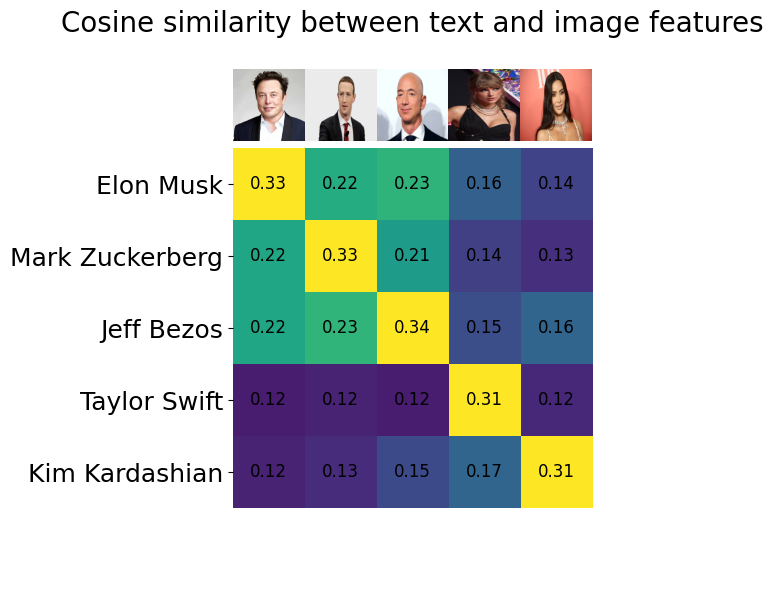

/tmp/ipykernel_336539/837987722.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


Celeb classification for Elon_Musk: top1: 100.00, top5: 100.00
Celeb classification for Mark_Zuckerberg: top1: 95.00, top5: 95.00
Celeb classification for Jeff_Bezos: top1: 100.00, top5: 100.00
Celeb classification for Taylor_Swift: top1: 16.00, top5: 100.00
Celeb classification for Kim_Kardashian: top1: 80.95, top5: 90.48


In [10]:
urls = [
    "https://futureoflife.org/wp-content/uploads/2020/08/elon_musk_royal_society.jpg",       
    "https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcToA87dFnKkkn7smBpTGguPNZ-2HJz3XGhiXNrvtybCGWLT869i",\
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRwhgRcyw94DdjP5cXCFSdC9oIlvc447C-GEqeeJlnRKrQ9RwVd",\
    "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Taylor_Swift_at_the_2023_MTV_Video_Music_Awards_%283%29.png/220px-Taylor_Swift_at_the_2023_MTV_Video_Music_Awards_%283%29.png",\
    "https://variety.com/wp-content/uploads/2023/10/GettyImages-1485742278.jpg?w=1024"
]
texts = ["Elon Musk", "Mark Zuckerberg", "Jeff Bezos", "Taylor Swift", "Kim Kardashian"]

original_images = []
images = []
for url, name in zip(urls, texts):
    image = Image.open(requests.get(url, stream=True).raw)
    image = image.convert('RGB')
    # save_path = f"data/cosine_matrix/{name}.jpg"
    # image.save(save_path)
    original_images.append(image)
    images.append(image)


with torch.no_grad(), torch.cuda.amp.autocast():
    inputs = processor_clip(text=texts, images=images, return_tensors="pt", padding=True).to(device)
    outputs = model_clip_pretrained(**inputs)
    image_features = outputs.image_embeds
    text_features = outputs.text_embeds
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T


plot_image_text_matrix(similarity, texts, original_images, title="Cosine similarity between text and image features")


# evaluate quantitative
for name in texts:
    name = name.replace(' ', '_')
    top1, top5 = run_name(model_clip_pretrained, classifier_celeb, name, processor_clip, device)
    print(f"Celeb classification for {name}: top1: {top1*100:.2f}, top5: {top5*100:.2f}")

# top1, top5 = run(model_pretrained, classifier_imagenet, data_imagenet.dataloader, args)
# print(f"imagenet zeroshot top1: {top1*100:.2f}%, top5: {top5*100:.2f}%")

#### Binary search for a step size

In [11]:
# with torch.no_grad():
#     important_layers = get_important_layers(celeb_name, pair, model_clip_pretrained, forget_grads, retain_grads)
# important_layers

{'language': ['text_projection.weight',
  'visual_projection.weight',
  'text_model.encoder.layers.23.mlp.fc1.weight',
  'text_model.encoder.layers.22.self_attn.v_proj.weight',
  'text_model.encoder.layers.20.self_attn.k_proj.weight',
  'text_model.encoder.layers.17.self_attn.k_proj.weight',
  'text_model.encoder.layers.12.self_attn.q_proj.weight']}

In [12]:
# # use the deepest layer on pareto-front for unlearning by default
# layer_num_max = 0
# layer_name_max = None
# for layer_name in important_layers['language']:
#     if not 'text_model.encoder.layers' in layer_name: continue
#     layer_num = int(layer_name.split('.')[3])
#     if layer_num > layer_num_max:
#         layer_num_max = layer_num
#         layer_name_max = layer_name
# if layer_name_max is None:
#     layer_name_max = "text_model.encoder.layers.11.self_attn.out_proj.weight"
# layer_name = layer_name_max
# # make sure update the whole layer
# layer_component = layer_name.split('.')[5]
# if layer_component in ['k_proj', 'v_proj', 'q_proj']:
#     layer_names = [layer_name.replace(layer_component, attn) for attn in ('k_proj', 'v_proj', 'q_proj')]
# elif layer_component in ['fc1', 'fc2']:
#     layer_names = [layer_name.replace(layer_component, attn) for attn in ('fc1', 'fc2')]
# else:
#     layer_names = [layer_name]
# # compute gradient alignment
# vector = forget_grads[layer_name].to(device)
# params_norm = torch.norm(model_clip_pretrained.get_parameter(layer_name)).item()
# grad_norm = torch.norm(vector).item()
# ratio = params_norm/grad_norm

# print(f"Layer name: {layer_name}")
# print(f"params_norm: {params_norm}")
# print(f"grad_norm: {grad_norm}")
# print(f"ratio: {ratio}")    

Layer name: text_model.encoder.layers.23.mlp.fc1.weight
params_norm: 26.2432918548584
grad_norm: 54.84423828125
ratio: 0.4785059046727682


In [13]:
# # evaluate quantitative
# test_top1_original = []
# test_top5_original = []
# for name in texts:
#     name = name.replace(' ', '_')
#     with torch.no_grad():
#         top1, top5 = run_name(model_clip_pretrained, classifier_celeb, name, processor_clip, device)
#     if name == celeb_name.replace(' ', '_'):
#         forget_acc1 = top1
#         forget_acc5 = top5
#     else:
#         test_top1_original.append(top1)
#         test_top5_original.append(top5)
# test_top1_original = np.mean(test_top1_original)
# test_top5_original = np.mean(test_top5_original)
# print(f"Original Forget acc: Top-1={forget_acc1:.2f}, Top-5={forget_acc5:.2f}")
# print(f"Original Retain acc: Top-1={test_top1_original:.2f}, Top-5={test_top5_original:.2f}")

/tmp/ipykernel_336539/837987722.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


Original Forget acc: Top-1=1.00, Top-5=1.00
Original Retain acc: Top-1=0.73, Top-5=0.96


In [ ]:
# # Bineary seach for a unlearning step size
# # start from 1/10 of norm ratio
# cnt = 0 # search count
# while 1:
#     if cnt == 0:
#         step_size = - (ratio / 10) # start with 1/10 of norm ratio
#         r_lo = 0.0
#         r_hi = 10*step_size
#         print(f"start with ratio: {step_size}")
#     else:
#         if forget_acc1 == 0 and test_top1 < test_top1_original:
#             # redece changes
#             r_hi = step_size
#             step_size = (r_lo + r_hi)/2
#             print(f"[reduce r] iter: {cnt}, ratio: {step_size}, r_lo: {r_lo}, r_hi: {r_hi}")
#             # r = r/2

#         if forget_acc1 > 0 and (test_top1_original > test_top1 - 0.01):
#             # magnify the changes
#             r_lo = step_size
#             step_size = (r_lo + r_hi)/2
#             print(f"[increase r] iter: {cnt}, ratio: {step_size}, r_lo: {r_lo}, r_hi: {r_hi}")
#             # print(f"best r is {r*2}")

#         if (forget_acc1 == 0 and test_top1 > test_top1_original) or cnt > 10:
#             break
    
#     print(f"iter: {cnt}, ratio: {step_size}")
#     # Update CLIP for unlearning
#     model_clip_modified = deepcopy(model_clip_pretrained)
#     ### modify a certain layer
#     for layer_name in layer_names:
#         vector = forget_grads[layer_name].to(device)
#         model_clip_modified.get_parameter(layer_name).data = model_clip_pretrained.get_parameter(layer_name).data + step_size*vector    

#     # update CLIP classifier
#     classifier_celeb = build_classifiers(model_clip_modified, processor_clip)
        
#     # evaluate quantitative
#     test_top1 = []
#     test_top5 = []
#     for name in texts:
#         name = name.replace(' ', '_')
#         with torch.no_grad():
#             top1, top5 = run_name(model_clip_modified, classifier_celeb, name, processor_clip, device)
#         # print(f"Celeb classification for {name}: top1: {top1*100:.2f}, top5: {top5*100:.2f}")
#         if name == celeb_name.replace(' ', '_'):
#             forget_acc1 = top1
#             forget_acc5 = top5
#         else:
#             test_top1.append(top1)
#             test_top5.append(top5)
#     test_top1 = np.mean(test_top1)
#     test_top5 = np.mean(test_top5)

#     # test_top1, test_top5 = run(model, classifier_imagenet, data_imagenet.dataloader, args)
#     # print(f"imagenet zeroshot top1: {test_top1*100:.2f}%, top5: {test_top5*100:.2f}%")

#     info = f"iter: {cnt}, ratio: {step_size}, fgt_acc@1: {forget_acc1}, fgt_acc@5: {forget_acc5}, test_acc@1: {test_top1}, test_acc@5: {test_top5}"
#     print(info)

#     cnt += 1

#### Use pre-searched step size

In [18]:
# get pareto-front (important layers)
pair = "ViT-H-14 laion2B-s32B-b79K"
important_layers = get_important_layers(celeb_name, pair, model_clip_pretrained, forget_grads, retain_grads)

# directly modify the model using gradients
layer_name = "text_model.encoder.layers.11.self_attn.k_proj.weight"
layer_names = [layer_name.replace('k_proj', attn) for attn in ('k_proj', 'v_proj', 'q_proj')]

vector = forget_grads[layer_name].to(device)

# get weight norm and ratio
params_norm = torch.norm(model_clip_pretrained.get_parameter(layer_name)).item()
grad_norm = torch.norm(vector).item()
ratio = params_norm/grad_norm
print(f"params_norm: {params_norm}")
print(f"grad_norm: {grad_norm}")
print(f"ratio: {ratio}")

params_norm: 14.30949878692627
grad_norm: 5.118122577667236
ratio: 2.7958491751184913


In [26]:
# search start from 1/10 of norm ratio
# # elon
# r = -2 # best
r = ratio/20

# # taylor
# r = -0.159 # best
# r = -0.25

# # Bezos
# r = -3.4 # best

# # avocado chair
# r = -2.5 # best

# iron man
# r = -0.9 # best
# r = -1.8 #

# mickey_mouse text.11
# r = -3.2
# r = -6.4
# r = -5.4
# r = -5.2 # best
# r = -4.8
# r = -4.25

# mickey_mouse vision.10
# r = -6.4
# r = -13.0

### modify a certain layer of CLIP
model_clip = deepcopy(model_clip_pretrained)
for layer_name in layer_names:
    vector = forget_grads[layer_name].to(device)
    model_clip.get_parameter(layer_name).data = model_clip_pretrained.get_parameter(layer_name).data + r*vector

Evaluate unlearned CLIP

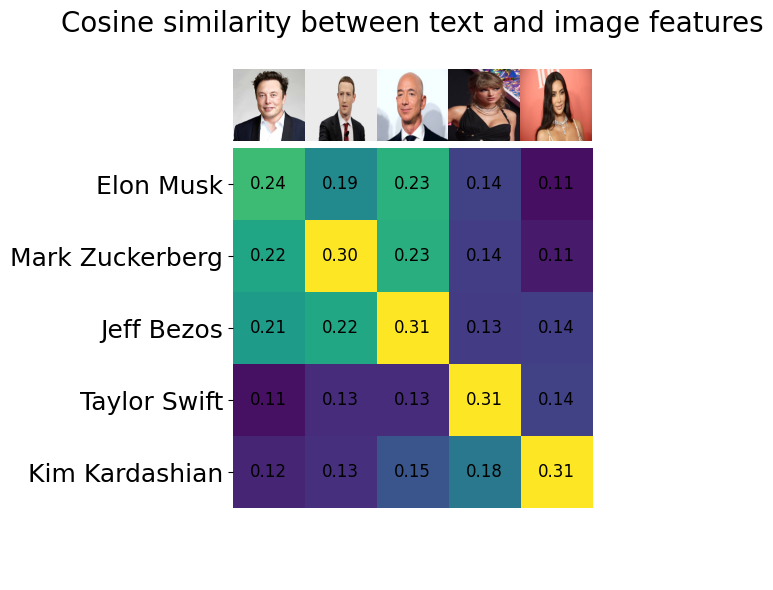

/tmp/ipykernel_336539/837987722.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


Celeb classification for Elon_Musk: top1: 38.89, top5: 100.00
Celeb classification for Mark_Zuckerberg: top1: 95.00, top5: 95.00
Celeb classification for Jeff_Bezos: top1: 100.00, top5: 100.00
Celeb classification for Taylor_Swift: top1: 100.00, top5: 100.00
Celeb classification for Kim_Kardashian: top1: 85.71, top5: 90.48


In [27]:
with torch.no_grad(), torch.cuda.amp.autocast():
    inputs = processor_clip(text=texts, images=images, return_tensors="pt", padding=True).to(device)
    outputs = model_clip(**inputs)

    image_features = outputs.image_embeds
    text_features = outputs.text_embeds
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T


plot_image_text_matrix(similarity, texts, original_images, title="Cosine similarity between text and image features")


# evaluate quantitative
for name in texts:
    name = name.replace(' ', '_')
    top1, top5 = run_name(model_clip, classifier_celeb, name, processor_clip, device)
    print(f"Celeb classification for {name}: top1: {top1*100:.2f}, top5: {top5*100:.2f}")

## Step 2: Unlearning Stable Diffusion

In [21]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
pipe_pretrained = None

/home/yt/miniconda3/envs/mu/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


100%|██████████| 50/50 [00:05<00:00,  8.34it/s]


Text(0.5, 1.0, "Original SD output for: 'A portrait photo of Elon Musk'")

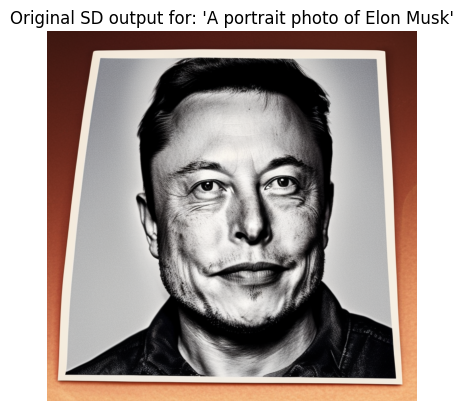

In [28]:
# load stable diffusion models and run
model_id = "stabilityai/stable-diffusion-2-1"

if pipe_pretrained is None:
    # Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
    pipe_pretrained = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    pipe_pretrained.scheduler = DPMSolverMultistepScheduler.from_config(pipe_pretrained.scheduler.config)
    pipe_pretrained = pipe_pretrained.to("cuda")

prompt = "A portrait photo of Elon Musk"
image = pipe_pretrained(prompt).images[0]
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.title(f"Original SD output for: '{prompt}'")

### Unlearning: Update corresponding layer of Stable Diffusion with update CLIP layer
If you wish to unlearn the target identity/concept, run the following cell

100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


Text(0.5, 1.0, "Unlearned SD output for: 'A portrait photo of Elon Musk'")

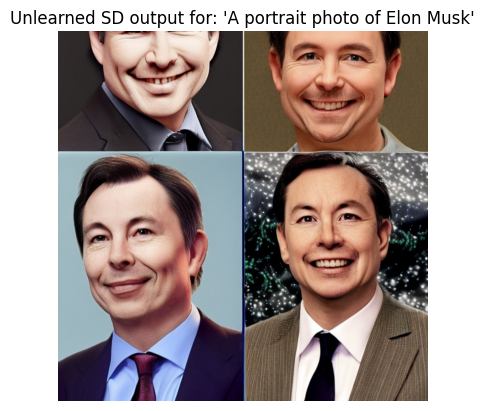

In [29]:
### Edit the model
pipe_unlearned = deepcopy(pipe_pretrained)
for idx, (n,p) in enumerate(pipe_unlearned.text_encoder.text_model.named_parameters()):
    p.data = model_clip.text_model.get_parameter(n).half() # cast to fp16
pipe_unlearned = pipe_unlearned.to("cuda")

prompt = "A portrait photo of Elon Musk"
image = pipe_unlearned(prompt).images[0]
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.title(f"Unlearned SD output for: '{prompt}'")

### Test unlearned Stable Diffusion with other prompts

100%|██████████| 50/50 [00:06<00:00,  7.92it/s]


Text(0.5, 1.0, "Unlearned SD output for: 'A portrait photo of Mark Zuckerberg'")

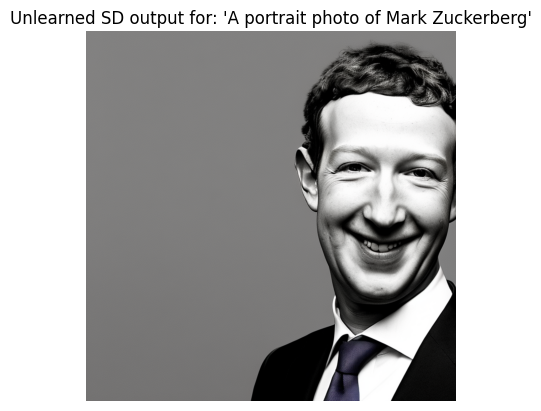

In [30]:
# # Example prompts:

# prompt = "A portrait photo of Elon Musk"
# prompt = "Elon Musk on Mars"

prompt = "A portrait photo of Mark Zuckerberg"
# prompt = "a portrait of Kim Kardashian"
# prompt = "a portrait of Kanye West"


# prompt = "A portrait photo of Taylor Swift"
# prompt = "Taylor Swift singing"


# prompt = "A portrait of Jeff Bezos"
# prompt = "Jeff Bezos in a car"

# prompt = "A photo of an astronaut riding a horse on mars"
# prompt = "A cute cat jumping on a bed"
# prompt = "A sea turtle in the ocean"

# prompt = "an avocado chair"
# prompt = "an avocado"
# prompt = "an orange"
# prompt = "a chair"


# prompt = "iron man"
# prompt = "iron man and spiderman"
# prompt = "a piece of iron"

# prompt = "a mickey mouse"
# prompt = "a real mouse"
# prompt = "a mickey"
# prompt = 'Mickey Mouse'
# prompt = 'Mickey Mouse and friends'

image = pipe_unlearned(prompt).images[0]
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.title(f"Unlearned SD output for: '{prompt}'")

### Generate the forget set from Stable Diffusion

Step1: Generate images from SD with given prompt

In [44]:
#TODO: update "n_images", number of images to generate as forget set
# update
n_images = 10
# n_images = 500
# concept = 'avocado_chair'
# concept = 'iron_man'
# concept = 'mickey_mouse'
concept = 'spider_man'
forget_data_root = Path(f'data/sd_gen/{concept}')
forget_data_root.mkdir(parents=True, exist_ok=True)

# # avocado_chair
# prompt = "an avocado chair"
# for i in tqdm(range(n_images)):
#     image = pipe_pretrained(prompt).images[0]
#     image.save(forget_data_root/f'avocado_chair_{i}.png')
#     with open(forget_data_root/f'avocado_chair_{i}.txt', "w") as file:
#         file.write(prompt)
        
# # iron_man
# prompt = "an iron man"
# for i in tqdm(range(n_images)):
#     image = pipe_pretrained(prompt).images[0]
#     image.save(forget_data_root/f'iron_man_{i}.png')
#     with open(forget_data_root/f'iron_man_{i}.txt', "w") as file:
#         file.write(prompt)

# # mickey_mouse
# prompt = "Mickey Mouse"
# for i in tqdm(range(n_images)):
#     image = pipe_pretrained(prompt).images[0]
#     image.save(forget_data_root/f'mickey_mouse_{i}.png')
#     with open(forget_data_root/f'mickey_mouse_{i}.txt', "w") as file:
#         file.write(prompt)


prompt = concept
for i in tqdm(range(n_images)):
    image = pipe_pretrained(prompt).images[0]
    image.save(forget_data_root/f'{concept}_{i}.png')
    with open(forget_data_root/f'{concept}_{i}.txt', "w") as file:
        file.write(prompt)
        
        

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


Step2: Create the forget set TAR file from generated images

In [46]:
import os
import tarfile
from tqdm import tqdm

def convert_png_to_jpg(png_path):
    # Open the PNG image
    with Image.open(png_path) as img:
        # Convert to RGB
        rgb_img = img.convert('RGB')
        # Save as JPG
        jpg_path = png_path.with_suffix('.jpg')
        rgb_img.save(jpg_path)
        return jpg_path


img_folder_path = forget_data_root
# img_folder_path = f'data/sd_gen/{concept}'

tar_save_path = Path(f"data/tar_files/{concept}/")
tar_save_path.mkdir(parents=True, exist_ok=True)


# List all files in the folder
files = os.listdir(img_folder_path)

# Group files by their base name (without extension)
file_groups = {}
for file in files:
    base_name, ext = os.path.splitext(file)
    if base_name not in file_groups:
        file_groups[base_name] = []
    file_groups[base_name].append(file)

# Create a TAR file to store the data
with tarfile.open(tar_save_path/f"{concept}.tar", "w") as tar:
    # Iterate over each base name group
    for base_name, group_files in tqdm(file_groups.items()):
        # Ensure both image and text files are present for each base name
        if len(group_files) == 2:
            image_file = None
            text_file = None
            # Find image and text files
            for file in group_files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    image_file = file
                elif file.endswith(".txt"):
                    text_file = file
            # If both image and text files are found, add them to the TAR file
            if image_file and text_file:
                image_path = os.path.join(img_folder_path, image_file)
                text_path = os.path.join(img_folder_path, text_file)
                # Convert PNG to JPG if necessary
                if image_file.endswith(".png"):
                    image_path = convert_png_to_jpg(Path(image_path))
                    image_file = image_path.name
                # Add image and text files to the TAR file with appropriate names
                tar.add(image_path, arcname=f"{image_file}")
                tar.add(text_path, arcname=f"{text_file}")
        else:
            image_file = None
            text_file = None
            for file in group_files:
                if file.endswith(".jpg"):
                    image_file = file
                elif file.endswith(".txt"):
                    text_file = file
            if image_file and text_file:
                image_path = os.path.join(img_folder_path, image_file)
                text_path = os.path.join(img_folder_path, text_file)                    
                
                tar.add(image_path, arcname=f"{image_file}")
                tar.add(text_path, arcname=f"{text_file}")        
            

print("TAR file created successfully.")

100%|██████████| 10/10 [00:00<00:00, 891.31it/s]

TAR file created successfully.
